In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1f9e88d2488>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1f9e88d2ac8>,
 'lr': <hyperopt.pyll.base.Apply at 0x1f9e88c3248>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1f9e88c3848>,
 'patience': <hyperopt.pyll.base.Apply at 0x1f9e88c3dc8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1f9e88b16c8>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1f9e88c8688>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1f9e88c8c08>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1f9e88cc1c8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

186

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = RNN
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 30}
RNN                                                                                                                    
  0%|                                                                           | 0/30 [00:30<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,0.966050,1.009900,0.665943,00:09
1,0.967999,0.951014,0.669176,00:09
2,0.967732,1.029187,0.657304,00:09
3,0.980773,0.986948,0.659283,00:10
4,0.980017,1.021628,0.660345,00:09
5,1.007533,1.097863,0.594518,00:09
6,1.053290,1.070746,0.659717,00:09
7,1.065771,1.123279,0.662565,00:09
8,1.049541,1.091403,0.666329,00:09
9,1.055542,1.091084,0.665508,00:09


No improvement since epoch 1: early stopping                                                                           
  0%|                                                                           | 0/30 [02:28<?, ?trial/s, best loss=?]

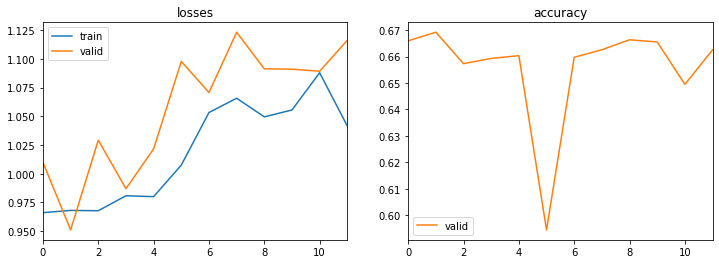

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
  3%|█▌                                             | 1/30 [02:58<1:11:52, 148.70s/trial, best loss: 1.116294264793396]

epoch,train_loss,valid_loss,accuracy,time
0,1.258798,1.114149,0.663771,00:02
1,1.075587,1.042154,0.644708,00:02
2,1.021221,0.980677,0.660827,00:02
3,1.026881,1.068579,0.656773,00:02
4,1.003633,1.016965,0.650113,00:02
5,0.989915,1.031192,0.661648,00:02
6,0.972527,1.003870,0.665701,00:02
7,0.972481,1.258168,0.632595,00:02
8,1.059421,1.099617,0.663530,00:02
9,1.055479,1.097071,0.662178,00:02


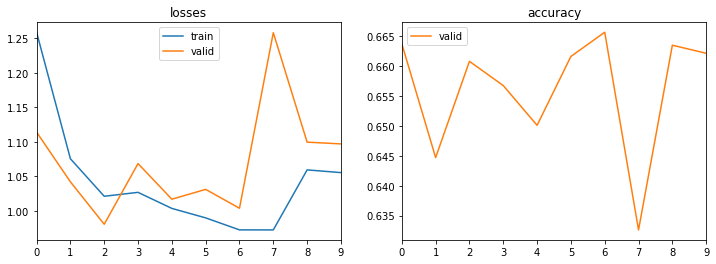

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 5, 'time_steps': 30}
RNN                                                                                                                    
  7%|███▏                                            | 2/30 [03:51<55:57, 119.90s/trial, best loss: 1.0970706939697266]

epoch,train_loss,valid_loss,accuracy,time
0,1.759564,1.758880,0.319724,00:06
1,1.686509,1.674498,0.515757,00:06
2,1.575460,1.559529,0.654216,00:06
3,1.483443,1.459698,0.664543,00:05
4,1.401226,1.383371,0.664543,00:05
5,1.349016,1.331749,0.664543,00:06
6,1.321620,1.300916,0.664543,00:06
7,1.307280,1.285250,0.664543,00:05
8,1.300513,1.279429,0.664543,00:06
9,1.296745,1.278604,0.664543,00:06


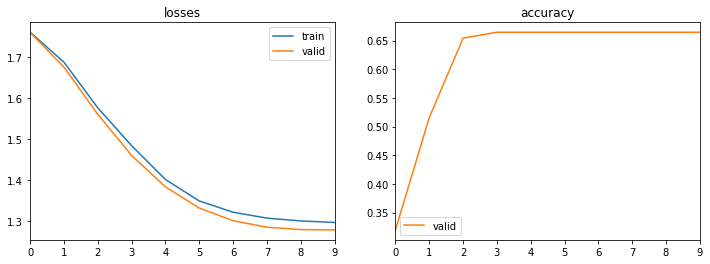

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 30}
RNN                                                                                                                    
 10%|████▊                                           | 3/30 [05:22<50:05, 111.31s/trial, best loss: 1.0970706939697266]

epoch,train_loss,valid_loss,accuracy,time
0,1.629420,1.437903,0.655519,00:02
1,1.171795,1.078590,0.655132,00:02
2,1.049147,1.001355,0.650741,00:02
3,0.987237,0.977921,0.655808,00:02
4,0.967618,0.950101,0.667970,00:02
5,0.957791,0.951345,0.672168,00:02
6,0.953803,0.941257,0.671927,00:02
7,0.949415,0.945208,0.672747,00:02
8,0.951518,0.947025,0.672554,00:02
9,0.948482,0.946195,0.672940,00:02


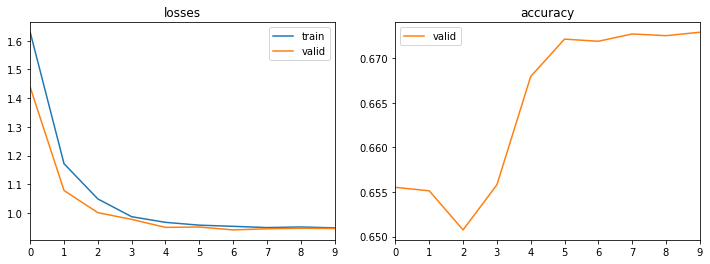

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
 13%|██████▌                                          | 4/30 [06:12<40:34, 93.65s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,0.953885,0.940091,0.668404,00:05
1,0.939220,0.968734,0.661117,00:04
2,0.941869,0.981103,0.663819,00:04
3,0.934818,0.930043,0.670383,00:04
4,0.964111,1.027676,0.664881,00:04
5,1.064318,1.080588,0.662178,00:04
6,1.021852,1.072618,0.660586,00:04
7,1.075585,1.098792,0.664061,00:04
8,1.102752,1.146996,0.660055,00:04
9,1.090371,1.111504,0.662902,00:04


No improvement since epoch 3: early stopping                                                                           
 13%|██████▌                                          | 4/30 [07:20<40:34, 93.65s/trial, best loss: 0.9461950659751892]

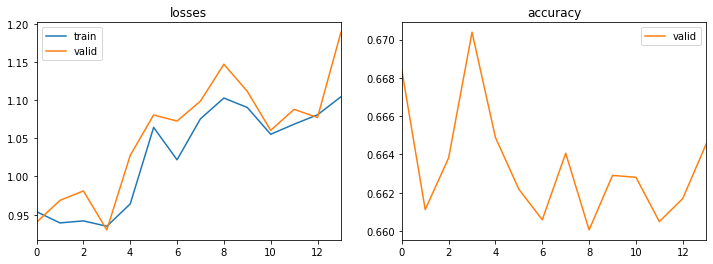

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 17%|████████▏                                        | 5/30 [07:48<39:18, 94.32s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,1.833812,1.836855,0.075141,00:23
1,1.826081,1.828393,0.082670,00:24
2,1.814112,1.813663,0.095217,00:25
3,1.793404,1.790498,0.133681,00:25
4,1.763375,1.757752,0.253752,00:25
5,1.724198,1.715279,0.522079,00:24
6,1.675797,1.663654,0.649776,00:25
7,1.619944,1.603862,0.663626,00:25
8,1.556833,1.537146,0.664543,00:24
9,1.488318,1.465492,0.664543,00:24


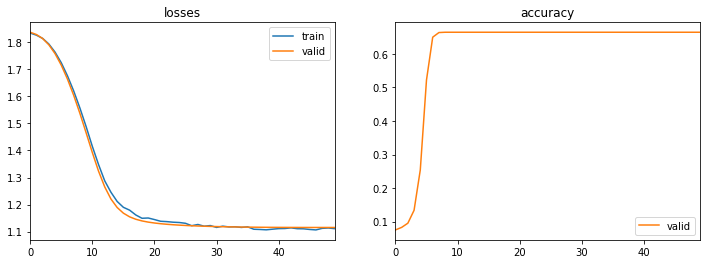

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
 20%|█████████▏                                    | 6/30 [29:24<3:01:39, 454.15s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,1.779452,1.773187,0.123305,00:07
1,1.777515,1.770751,0.130110,00:07
2,1.774036,1.766443,0.146132,00:07
3,1.768198,1.759497,0.174605,00:07
4,1.759763,1.749362,0.223155,00:07
5,1.747663,1.735693,0.304039,00:07
6,1.732229,1.718434,0.417837,00:07
7,1.713559,1.697771,0.547174,00:07
8,1.691421,1.674112,0.632064,00:07
9,1.666469,1.648030,0.656049,00:07


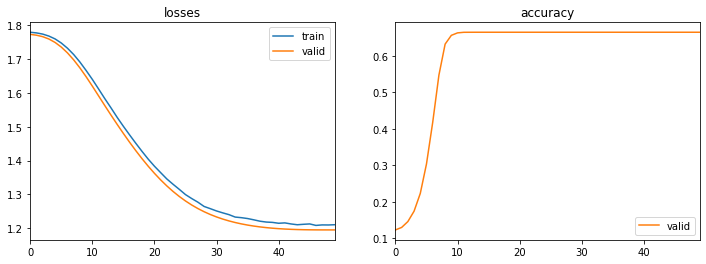

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 10, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 23%|██████████▋                                   | 7/30 [36:06<2:48:23, 439.28s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,1.069994,1.033671,0.654360,00:10
1,1.014762,1.008561,0.664302,00:10
2,1.028878,1.012385,0.661261,00:10
3,1.004462,1.055167,0.663240,00:10
4,1.005093,1.079127,0.667680,00:10
5,1.012234,1.103758,0.641282,00:10
6,1.044069,1.066321,0.657642,00:10


No improvement since epoch 1: early stopping                                                                           
 23%|██████████▋                                   | 7/30 [37:20<2:48:23, 439.28s/trial, best loss: 0.9461950659751892]

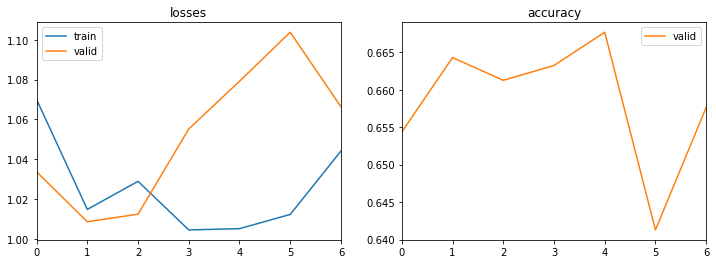

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 30}
RNN                                                                                                                    
 27%|████████████▎                                 | 8/30 [37:50<2:03:54, 337.93s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,0.979990,0.972681,0.665364,00:04
1,0.971973,0.956899,0.662468,00:04
2,0.953057,1.022967,0.659428,00:04
3,0.975994,1.029547,0.658559,00:04
4,0.993749,1.042689,0.664736,00:04
5,1.019395,1.039201,0.662227,00:04
6,1.038322,1.027316,0.664543,00:04
7,1.106794,1.130202,0.655277,00:04
8,1.150959,1.193200,0.664543,00:04
9,1.129115,1.191449,0.664543,00:04


No improvement since epoch 1: early stopping                                                                           
 27%|████████████▎                                 | 8/30 [38:45<2:03:54, 337.93s/trial, best loss: 0.9461950659751892]

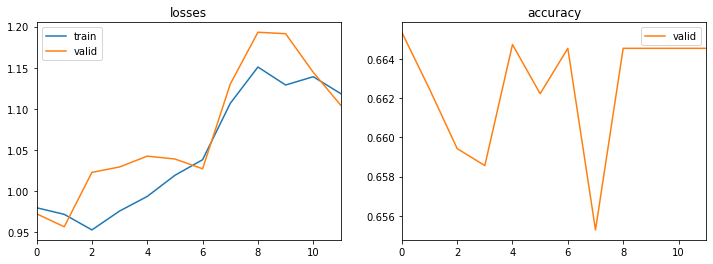

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 60}
RNN                                                                                                                    
 30%|█████████████▊                                | 9/30 [39:12<1:31:41, 261.96s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,1.047127,0.987791,0.658221,00:06
1,0.980079,0.973853,0.665701,00:06
2,0.971900,0.970182,0.663433,00:06
3,0.966834,0.916638,0.673037,00:06
4,0.963600,0.996421,0.656387,00:06
5,0.964260,0.966118,0.663095,00:06
6,0.978383,0.976938,0.669176,00:06
7,0.971790,0.969249,0.668308,00:06
8,1.054720,1.033311,0.658125,00:06


No improvement since epoch 3: early stopping                                                                           
 30%|█████████████▊                                | 9/30 [40:08<1:31:41, 261.96s/trial, best loss: 0.9461950659751892]

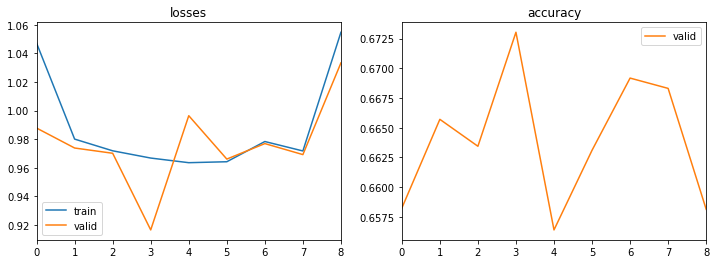

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 10, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 60}
RNN                                                                                                                    
 33%|███████████████                              | 10/30 [40:35<1:09:28, 208.42s/trial, best loss: 0.9461950659751892]

epoch,train_loss,valid_loss,accuracy,time
0,1.076862,1.013892,0.662082,00:05
1,0.955719,0.914570,0.665267,00:05
2,0.969486,0.971176,0.669707,00:05
3,0.951494,0.932193,0.659138,00:05
4,0.946275,0.921391,0.669224,00:05
5,0.923032,0.905585,0.676608,00:05
6,0.900706,0.923279,0.675643,00:05
7,0.899994,0.924957,0.679600,00:05
8,0.889090,0.913981,0.680614,00:05
9,0.887371,0.906318,0.679697,00:05


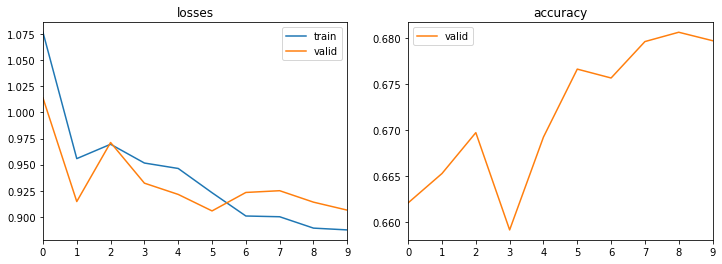

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 37%|█████████████████▏                             | 11/30 [42:00<54:05, 170.83s/trial, best loss: 0.9063182473182678]

epoch,train_loss,valid_loss,accuracy,time
0,1.717038,1.701682,0.457507,00:04
1,1.545650,1.512287,0.643598,00:04
2,1.221685,1.177891,0.664447,00:04
3,1.090826,1.066132,0.662758,00:04
4,1.051170,1.025132,0.664205,00:04
5,1.011000,0.981161,0.660103,00:04
6,0.981217,0.937238,0.661841,00:05
7,0.959684,0.925105,0.665412,00:04
8,0.948564,0.922170,0.664061,00:04
9,0.940429,0.906976,0.667198,00:04


No improvement since epoch 18: early stopping                                                                          
 37%|█████████████████▏                             | 11/30 [43:50<54:05, 170.83s/trial, best loss: 0.9063182473182678]

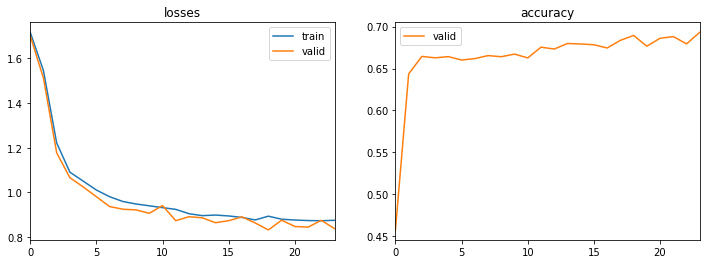

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 30}
RNN                                                                                                                    
 40%|██████████████████▊                            | 12/30 [44:19<48:20, 161.13s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.370988,1.129045,0.664447,00:01
1,1.095979,1.052788,0.659476,00:01
2,0.999679,0.972828,0.663723,00:01
3,0.966646,0.942564,0.665895,00:01
4,0.954885,0.939442,0.671637,00:01
5,0.950513,0.956628,0.663481,00:01
6,0.941906,0.945285,0.667294,00:01
7,0.935567,0.945686,0.670576,00:01
8,0.932696,0.941714,0.671541,00:01
9,0.932001,0.939751,0.672120,00:01


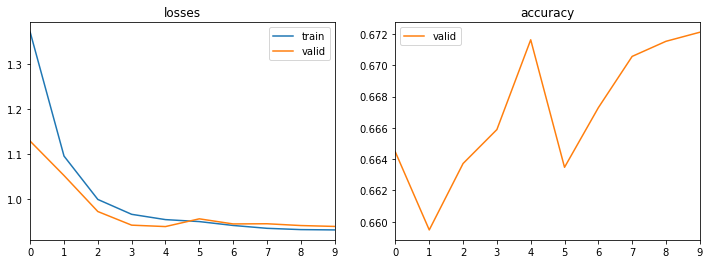

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 10, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 10, 'time_steps': 30}
RNN                                                                                                                    
 43%|████████████████████▎                          | 13/30 [45:02<35:31, 125.38s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.695695,1.666874,0.645867,00:04
1,1.225999,1.167087,0.664543,00:04
2,1.133931,1.118044,0.664543,00:04
3,1.115134,1.109737,0.664543,00:04
4,1.099565,1.104902,0.663433,00:04
5,1.088220,1.100675,0.656966,00:04
6,1.083483,1.096714,0.655084,00:04
7,1.090057,1.094224,0.653878,00:04
8,1.075843,1.093278,0.653636,00:04
9,1.082478,1.093153,0.653588,00:04


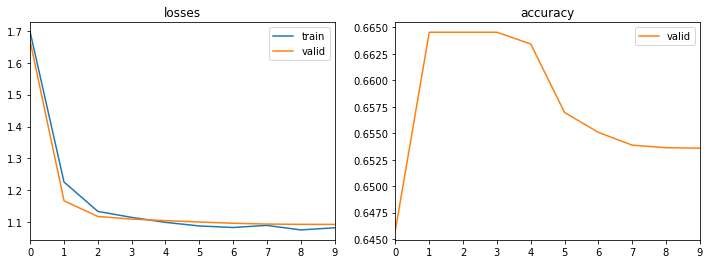

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 5, 'time_steps': 60}
RNN                                                                                                                    
 47%|█████████████████████▉                         | 14/30 [46:11<29:08, 109.30s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.752681,1.720110,0.334781,00:03
1,1.547579,1.480659,0.645915,00:03
2,1.183274,1.130789,0.659572,00:03
3,1.071239,1.078469,0.650403,00:03
4,1.036492,1.011623,0.659283,00:03
5,0.987439,0.937441,0.658173,00:03
6,0.952406,0.936126,0.656870,00:03
7,0.941574,0.925462,0.665557,00:03
8,0.927986,0.904706,0.668645,00:03
9,0.917458,0.916048,0.669321,00:03


No improvement since epoch 12: early stopping                                                                          
 47%|█████████████████████▉                         | 14/30 [47:20<29:08, 109.30s/trial, best loss: 0.8383311629295349]

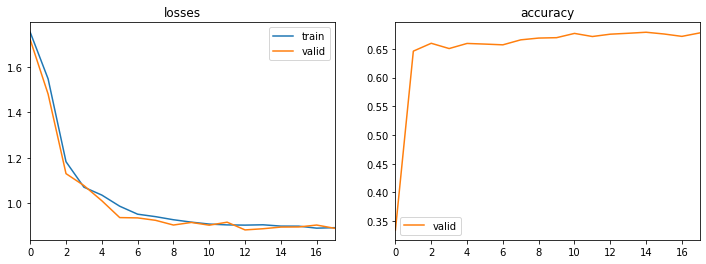

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
 50%|███████████████████████▌                       | 15/30 [47:48<26:20, 105.34s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.617666,1.392460,0.664447,00:02
1,1.182036,1.108754,0.651851,00:02
2,1.084912,1.035468,0.658462,00:02
3,1.028048,0.984106,0.654698,00:02
4,0.976156,0.932247,0.658945,00:02
5,0.931285,0.902113,0.664061,00:02
6,0.916024,0.903662,0.666039,00:02
7,0.899107,0.877177,0.675209,00:02
8,0.893823,0.885755,0.676126,00:02
9,0.886773,0.885874,0.681193,00:02


No improvement since epoch 38: early stopping                                                                          
 50%|███████████████████████▌                       | 15/30 [49:34<26:20, 105.34s/trial, best loss: 0.8383311629295349]

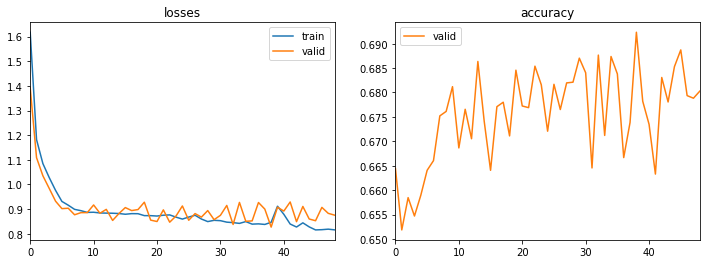

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
 53%|█████████████████████████                      | 16/30 [50:02<26:35, 113.94s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.111898,1.074850,0.652816,00:06
1,0.987151,0.966049,0.663047,00:05
2,0.941771,0.942505,0.661937,00:06
3,0.934225,0.909041,0.671155,00:05
4,0.918571,0.884930,0.674340,00:06
5,0.909108,0.903501,0.681048,00:06
6,0.886727,0.889665,0.675354,00:05
7,0.918819,0.926178,0.670093,00:06
8,0.930306,0.939995,0.680131,00:06
9,0.993552,0.962169,0.667246,00:06


No improvement since epoch 4: early stopping                                                                           
 53%|█████████████████████████                      | 16/30 [51:32<26:35, 113.94s/trial, best loss: 0.8383311629295349]

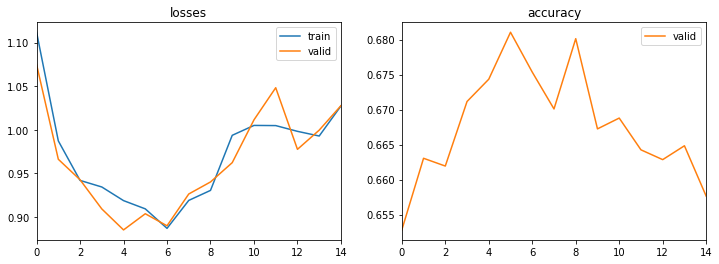

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function SGD at 0x000001F9A877A0D8>, 'patience': 10, 'time_steps': 30}
RNN                                                                                                                    
 57%|██████████████████████████▋                    | 17/30 [52:00<24:57, 115.22s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.117774,1.120842,0.664543,00:06
1,1.081766,1.114998,0.656918,00:06
2,1.068976,1.095966,0.651175,00:06
3,1.025067,1.029611,0.649148,00:06
4,0.998929,0.993450,0.659186,00:06
5,0.977575,0.987695,0.664157,00:06
6,0.984185,0.963636,0.664640,00:06
7,0.983120,0.954320,0.664881,00:06
8,0.955617,0.940144,0.669948,00:06
9,0.964167,0.950179,0.665315,00:06


No improvement since epoch 14: early stopping                                                                          
 57%|██████████████████████████▋                    | 17/30 [54:36<24:57, 115.22s/trial, best loss: 0.8383311629295349]

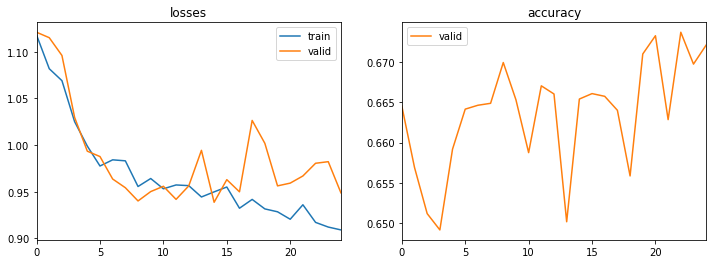

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 30}
RNN                                                                                                                    
 60%|████████████████████████████▏                  | 18/30 [55:03<27:09, 135.75s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.443224,1.415240,0.138217,00:06
1,1.549506,1.933273,0.657063,00:06
2,1.771009,1.310952,0.656098,00:06
3,2.088686,1.809456,0.561701,00:06
4,2.974250,2.805630,0.305873,00:06
5,3.825539,2.773295,0.489310,00:06
6,4.812616,8.381893,0.504319,00:06
7,6.256962,5.360633,0.308093,00:06


No improvement since epoch 2: early stopping                                                                           
 60%|████████████████████████████▏                  | 18/30 [55:58<27:09, 135.75s/trial, best loss: 0.8383311629295349]

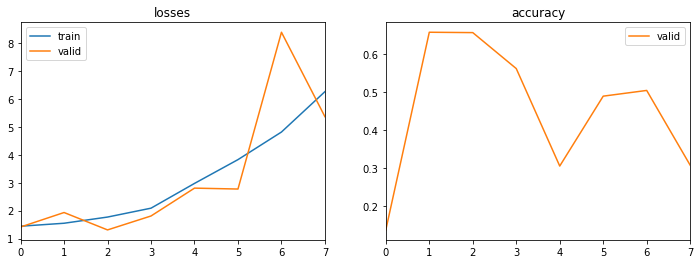

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 30}
RNN                                                                                                                    
 63%|█████████████████████████████▊                 | 19/30 [56:26<21:58, 119.87s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,0.983773,0.959211,0.669031,00:02
1,0.991845,0.970842,0.670334,00:02
2,1.005853,1.051131,0.668163,00:02
3,1.017858,1.029009,0.662999,00:02
4,1.026234,1.085654,0.660779,00:02
5,1.047231,1.164473,0.657497,00:02


No improvement since epoch 0: early stopping                                                                           
 63%|█████████████████████████████▊                 | 19/30 [56:42<21:58, 119.87s/trial, best loss: 0.8383311629295349]

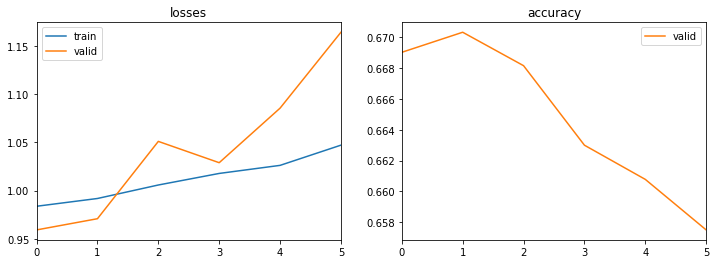

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 67%|████████████████████████████████                | 20/30 [57:10<16:11, 97.11s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.064745,0.987113,0.662082,00:04
1,0.999560,0.955983,0.660731,00:04
2,0.956595,0.915336,0.661696,00:04
3,0.943680,0.936533,0.662902,00:04
4,0.942532,0.928474,0.662323,00:04
5,0.946423,0.931416,0.661020,00:04
6,0.946322,0.895355,0.664591,00:04
7,0.950546,0.949635,0.659283,00:04
8,0.949678,1.038586,0.653926,00:04
9,0.991891,0.989308,0.644467,00:04


No improvement since epoch 6: early stopping                                                                           
 67%|████████████████████████████████                | 20/30 [58:01<16:11, 97.11s/trial, best loss: 0.8383311629295349]

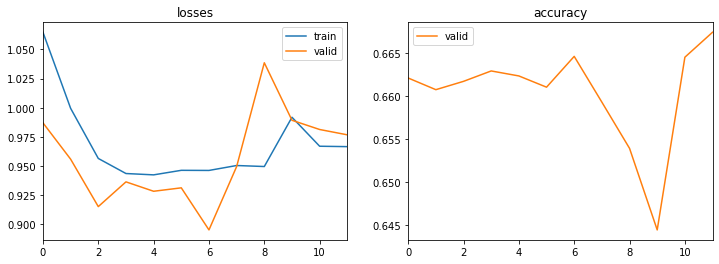

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 70%|█████████████████████████████████▌              | 21/30 [58:29<13:43, 91.52s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.695153,1.632238,0.653878,00:04
1,1.499685,1.366088,0.664640,00:04
2,1.233814,1.137366,0.664447,00:04
3,1.127719,1.091282,0.658993,00:04
4,1.085825,1.043832,0.659524,00:04
5,1.057570,1.002639,0.669562,00:04
6,1.025816,0.975188,0.660634,00:04
7,0.988229,0.933294,0.662082,00:04
8,0.952476,0.928428,0.657690,00:04
9,0.938985,0.907772,0.660055,00:04


No improvement since epoch 17: early stopping                                                                          
 70%|████████████████████████████████▏             | 21/30 [1:00:07<13:43, 91.52s/trial, best loss: 0.8383311629295349]

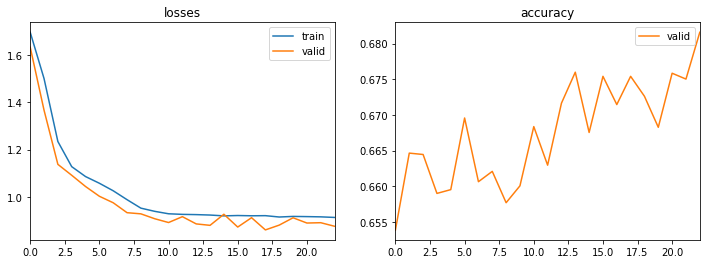

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 73%|█████████████████████████████████            | 22/30 [1:00:35<13:35, 101.93s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.740584,1.749191,0.242990,00:01
1,1.716089,1.722359,0.345978,00:01
2,1.686937,1.689379,0.438589,00:01
3,1.647575,1.643081,0.527774,00:01
4,1.589981,1.571909,0.598282,00:01
5,1.498327,1.458457,0.641089,00:01
6,1.365448,1.299844,0.657159,00:01
7,1.231220,1.172326,0.659428,00:01
8,1.148286,1.115041,0.655953,00:01
9,1.103354,1.080734,0.656146,00:01


No improvement since epoch 25: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:01:25<13:35, 101.93s/trial, best loss: 0.8383311629295349]

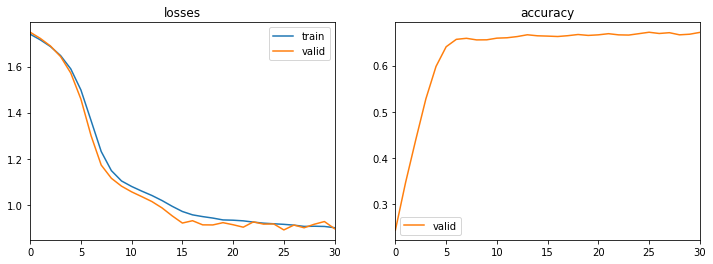

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 10, 'time_steps': 90}
RNN                                                                                                                    
 77%|███████████████████████████████████▎          | 23/30 [1:01:53<11:03, 94.77s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.400717,1.238732,0.661310,00:01
1,1.156991,1.088835,0.661985,00:01
2,1.096343,1.047316,0.670093,00:01
3,1.067563,1.026103,0.665895,00:01
4,1.027866,0.978414,0.654843,00:01
5,0.990258,0.923913,0.666618,00:01
6,0.973357,0.919670,0.671155,00:01
7,0.963921,0.927700,0.668549,00:01
8,0.957421,0.907733,0.670962,00:01
9,0.955648,0.923130,0.670431,00:01


No improvement since epoch 8: early stopping                                                                           
 77%|███████████████████████████████████▎          | 23/30 [1:02:24<11:03, 94.77s/trial, best loss: 0.8383311629295349]

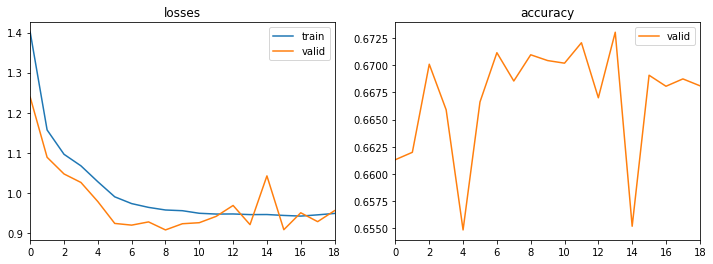

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 80%|████████████████████████████████████▊         | 24/30 [1:02:52<08:23, 83.95s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.592224,1.524513,0.661406,00:01
1,1.365170,1.251377,0.662178,00:01
2,1.167154,1.116340,0.656387,00:01
3,1.094464,1.057381,0.661985,00:01
4,1.038652,0.983519,0.658993,00:01
5,0.986538,0.933000,0.667053,00:01
6,0.962683,0.927580,0.669418,00:01
7,0.939886,0.918980,0.669948,00:01
8,0.923873,0.903769,0.672603,00:01
9,0.914994,0.870109,0.682930,00:01


No improvement since epoch 14: early stopping                                                                          
 80%|████████████████████████████████████▊         | 24/30 [1:03:26<08:23, 83.95s/trial, best loss: 0.8383311629295349]

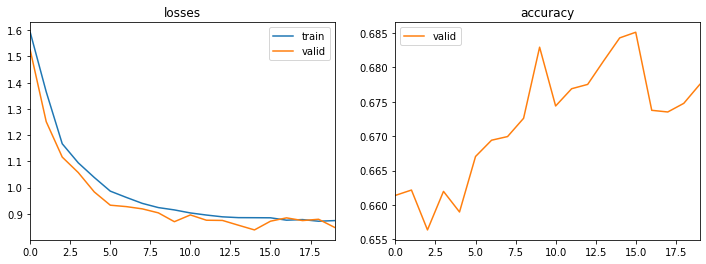

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 60}
RNN                                                                                                                    
 83%|██████████████████████████████████████▎       | 25/30 [1:03:57<06:27, 77.54s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.763362,1.772444,0.213600,00:03
1,1.593967,1.594636,0.572366,00:04
2,1.237791,1.234330,0.640510,00:03
3,1.097251,1.094650,0.653395,00:03
4,1.053184,1.024142,0.656146,00:03
5,0.990844,0.953820,0.660055,00:03
6,0.971776,0.938974,0.661455,00:03
7,0.964311,0.942988,0.662902,00:03
8,0.958830,0.938280,0.663771,00:03
9,0.941225,0.953023,0.663240,00:03


No improvement since epoch 22: early stopping                                                                          
 83%|██████████████████████████████████████▎       | 25/30 [1:05:47<06:27, 77.54s/trial, best loss: 0.8383311629295349]

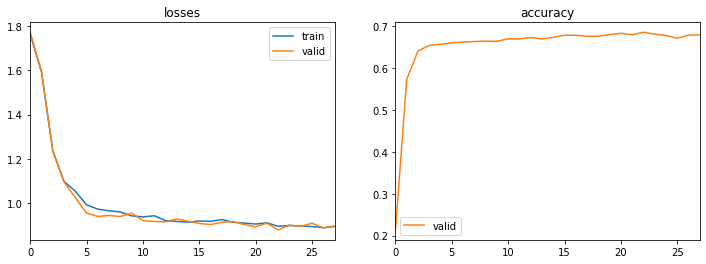

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 87%|███████████████████████████████████████▊      | 26/30 [1:06:15<06:25, 96.45s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.745496,1.755868,0.281261,00:02
1,1.721609,1.731317,0.336856,00:02
2,1.691067,1.697980,0.401670,00:02
3,1.643658,1.648843,0.464119,00:02
4,1.570249,1.571723,0.529559,00:02
5,1.447358,1.436575,0.599392,00:02
6,1.246250,1.225375,0.650789,00:02
7,1.145048,1.135787,0.659862,00:02
8,1.104993,1.109748,0.657594,00:02
9,1.091685,1.089132,0.654505,00:02


No improvement since epoch 31: early stopping                                                                          
 87%|███████████████████████████████████████▊      | 26/30 [1:07:31<06:25, 96.45s/trial, best loss: 0.8383311629295349]

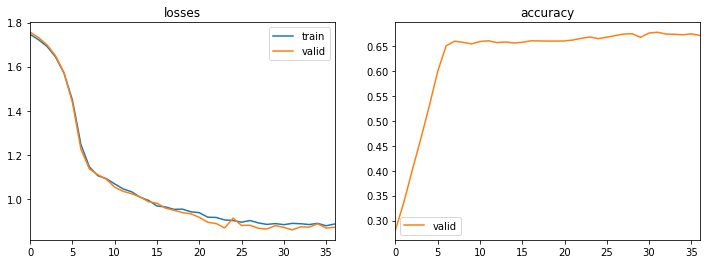

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 90%|█████████████████████████████████████████▍    | 27/30 [1:08:00<04:56, 98.81s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.401396,1.226306,0.664157,00:01
1,1.157100,1.068578,0.662806,00:01
2,1.075290,1.023670,0.657739,00:01
3,1.020279,0.997271,0.656677,00:01
4,0.988216,0.945326,0.664495,00:01
5,0.970023,0.964107,0.662516,00:01
6,0.961590,0.950100,0.661358,00:01
7,0.961991,0.989777,0.663771,00:01
8,0.959674,0.974946,0.664881,00:01
9,0.958414,0.925079,0.663337,00:01


No improvement since epoch 10: early stopping                                                                          
 90%|█████████████████████████████████████████▍    | 27/30 [1:08:27<04:56, 98.81s/trial, best loss: 0.8383311629295349]

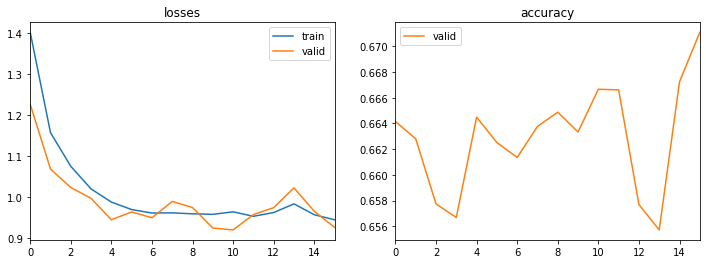

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 5, 'time_steps': 90}
RNN                                                                                                                    
 93%|██████████████████████████████████████████▉   | 28/30 [1:08:54<02:51, 85.74s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,0.980885,0.957816,0.661213,00:04
1,0.962482,0.914364,0.669707,00:04
2,0.983724,1.037268,0.659862,00:04
3,1.008100,1.026749,0.664591,00:04
4,1.009744,1.030387,0.654119,00:04
5,0.995029,1.003646,0.665798,00:04
6,0.995578,0.987802,0.668308,00:04


No improvement since epoch 1: early stopping                                                                           
 93%|██████████████████████████████████████████▉   | 28/30 [1:09:27<02:51, 85.74s/trial, best loss: 0.8383311629295349]

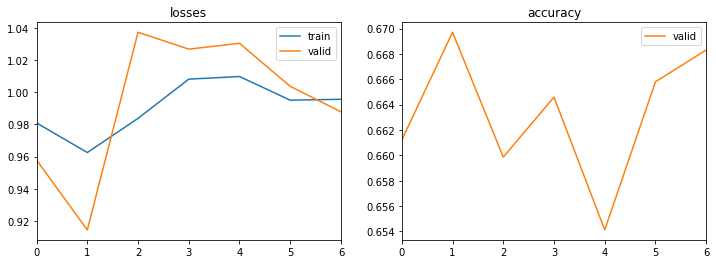

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000001F9A877A438>, 'patience': 5, 'time_steps': 60}
RNN                                                                                                                    
 97%|████████████████████████████████████████████▍ | 29/30 [1:09:55<01:18, 78.22s/trial, best loss: 0.8383311629295349]

epoch,train_loss,valid_loss,accuracy,time
0,1.093742,1.072155,0.664061,00:04
1,1.077940,1.098907,0.657449,00:04
2,1.097369,1.096685,0.657546,00:04
3,1.096636,1.133510,0.646976,00:04
4,1.132491,1.125562,0.664543,00:04
5,1.156181,1.205157,0.664543,00:04


No improvement since epoch 0: early stopping                                                                           
 97%|████████████████████████████████████████████▍ | 29/30 [1:10:20<01:18, 78.22s/trial, best loss: 0.8383311629295349]

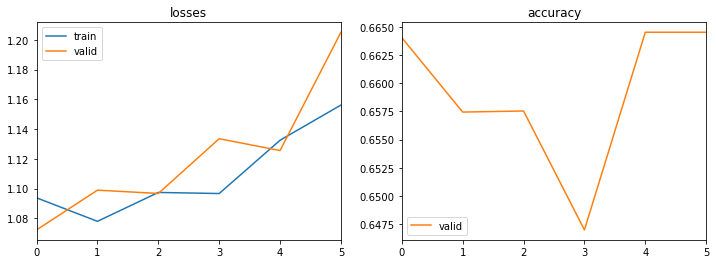

100%|█████████████████████████████████████████████| 30/30 [1:10:20<00:00, 140.70s/trial, best loss: 0.8383311629295349]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 1, 'bs': 0, 'epochs': 1, 'hidden_size': 0, 'lr': 3, 'n_layers': 1, 'optimizer': 2, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = RNN
    k = {
        'n_layers': params['n_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001F9A877A1F8>, 'patience': 5, 'time_steps': 90}
RNN


epoch,train_loss,valid_loss,accuracy,time
0,1.791409,1.775868,0.128855,00:04
1,1.617949,1.582245,0.628203,00:04
2,1.256988,1.198941,0.664543,00:04
3,1.106417,1.081176,0.666377,00:04
4,1.065761,1.049169,0.666474,00:04
5,1.030296,1.028429,0.658849,00:04
6,0.982764,0.961845,0.662227,00:04
7,0.957239,0.926750,0.664109,00:04
8,0.928786,0.911835,0.668259,00:04
9,0.917766,0.886823,0.670624,00:04


No improvement since epoch 16: early stopping


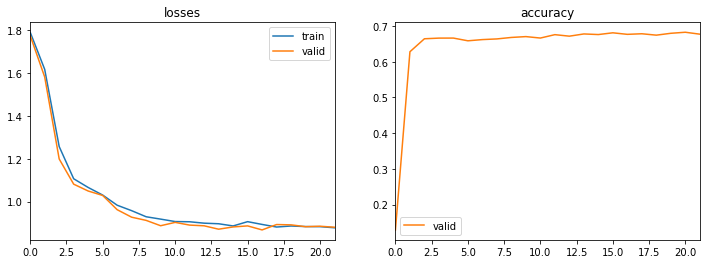

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[2.8989e-01, 3.0496e-01, 2.2408e-01, 1.3752e-01, 3.4699e-02, 8.8672e-03],
         [8.1253e-01, 1.2818e-01, 4.1628e-02, 1.3037e-02, 4.0037e-03, 6.2260e-04],
         [9.5988e-01, 2.8471e-02, 7.8566e-03, 3.1474e-03, 4.9260e-04, 1.5177e-04],
         ...,
         [9.7962e-01, 1.4296e-02, 4.0056e-03, 1.6248e-03, 3.3251e-04, 1.1697e-04],
         [9.7842e-01, 1.5371e-02, 4.2313e-03, 1.5525e-03, 3.0973e-04, 1.1470e-04],
         [9.4671e-01, 3.8543e-02, 1.0455e-02, 3.3869e-03, 7.0998e-04, 1.9326e-04]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.730060
f1 score:   0.676645


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_RNN', y_test_true)
np.save('y_pred_RNN', y_test_pred)